# feature selection & modelling 

In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import featuretools as ft


In [11]:
print(pd.__version__)
print(np.__version__)
print(ft.__version__)

1.1.5
1.19.2
0.23.1


In [12]:
df_target_merged = pd.read_csv('./dataset/target_merged.csv')

In [13]:
df_user_feature = pd.read_csv('./dataset/user_feature_total_remove_highcorr.csv')
df_merchant_feature = pd.read_csv('./dataset/merchant_feature_total_remove_highcorr.csv')
df_coupon_feature = pd.read_csv('./dataset/coupon_feature_total_remove_highcorr.csv')
df_user_merchant_feature = pd.read_csv('./dataset/user_merchant_feature.csv')
df_leakage_feature = pd.read_csv('./dataset/user_leakage_feature.csv')

In [14]:
df_user_feature = df_user_feature.add_prefix('user_')
df_merchant_feature = df_merchant_feature.add_prefix('merchant_')
df_coupon_feature = df_coupon_feature.add_prefix('coupon_')
df_user_merchant_feature = df_user_merchant_feature.add_prefix('user_merchant_')
df_leakage_feature = df_leakage_feature.add_prefix('leakage_')

## feature seletion 
To reduce modelling time and avoid the curse of dimensionality, feature selection is necessary for our project.

Traditional Methods of feature selection:

1. remove features with high missing rate 
2. remove features with singal value 
3. remove high correlated features 
4. univariate statistical test based 
5. model based

In [17]:
print('# user feature {}'.format(df_user_feature.shape[1]-2))
print('# merchant feature {}'.format(df_merchant_feature.shape[1]-2))
print('# coupon feature {}'.format(df_coupon_feature.shape[1]-2))

print('# user merchant feature {}'.format(df_user_merchant_feature.shape[1]-3))
print('# leakagre feature {}'.format(df_leakage_feature.shape[1]-2))

# user feature 73
# merchant feature 60
# coupon feature 39
# user merchant feature 21
# leakagre feature 16


In [20]:
73+60+39+21+16

209

In [21]:
df_target_merged[df_target_merged.data == 'Train']

,User_id,Merchant_id,Coupon_id,Date_received,Date,datediff,target,Month_received,data
0,1439408,4663,11002.0,2016-05-28,NaN,NaN,0.0,2016-05-01,Train
1,1439408,2632,8591.0,2016-02-17,NaN,NaN,0.0,2016-02-01,Train
2,1439408,2632,1078.0,2016-03-19,NaN,NaN,0.0,2016-03-01,Train
3,1439408,2632,8591.0,2016-06-13,NaN,NaN,0.0,2016-06-01,Train
4,1439408,2632,8591.0,2016-05-16,2016-06-13,28.0,-1.0,2016-05-01,Train
...,...,...,...,...,...,...,...,...,...
1053277,212662,3021,3739.0,2016-05-04,2016-05-08,4.0,1.0,2016-05-01,Train
1053278,212662,2934,5686.0,2016-03-21,2016-03-22,1.0,1.0,2016-03-01,Train
1053279,212662,3021,3739.0,2016-05-08,2016-06-02,25.0,-1.0,2016-05-01,Train
1053280,752472,7113,1633.0,2016-06-13,NaN,NaN,0.0,2016-06-01,Train


In [22]:
def cast_categorical_variable(df):
    cate_feat = list(
    filter(lambda x: 'MODE' in x , 
           df.columns)
    )
    df[cate_feat] = df[cate_feat].astype(object)
    return df

In [23]:
df_user_feature = cast_categorical_variable(df_user_feature)
df_merchant_feature = cast_categorical_variable(df_merchant_feature)
df_coupon_feature = cast_categorical_variable(df_coupon_feature)
df_user_merchant_feature = cast_categorical_variable(df_user_merchant_feature)
df_leakage_feature = cast_categorical_variable(df_leakage_feature)

In [24]:
df_train_target = df_target_merged[(df_target_merged['data'] == 'Train') & 
                                  (df_target_merged['target'] >= 0)][['User_id', 'Merchant_id',
                                     'Coupon_id', 'datediff','target','Month_received', 'Date_received']]

In [25]:
df_train_target

,User_id,Merchant_id,Coupon_id,datediff,target,Month_received,Date_received
0,1439408,4663,11002.0,NaN,0.0,2016-05-01,2016-05-28
1,1439408,2632,8591.0,NaN,0.0,2016-02-01,2016-02-17
2,1439408,2632,1078.0,NaN,0.0,2016-03-01,2016-03-19
3,1439408,2632,8591.0,NaN,0.0,2016-06-01,2016-06-13
5,1832624,3381,7610.0,NaN,0.0,2016-04-01,2016-04-29
...,...,...,...,...,...,...,...
1053276,212662,3532,5267.0,NaN,0.0,2016-03-01,2016-03-22
1053277,212662,3021,3739.0,4.0,1.0,2016-05-01,2016-05-04
1053278,212662,2934,5686.0,1.0,1.0,2016-03-01,2016-03-21
1053280,752472,7113,1633.0,NaN,0.0,2016-06-01,2016-06-13


### statistical based feature selection
Now, we have about 180 variables with some null values and categorical variables. In this part, we will use WoE(Weight of Evidence) transformation to save us from encoding and imputing, which is widely used in research credit risk world.

blog: https://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/

Steps:
1. to split (a continuous) variable into few categories or to group (a discrete) variable into few categories (and in both cases you assume that all observations in one category have "same" effect on dependent variable)
2. to calculate WoE value for each category (then the original x values are replaced by the WoE values)

Prons: (from the blog)
1. Seamlessly compare the strength of continuous and categorical variables without creating dummy variables.
2. Seamlessly handle missing values without imputation.
3. Assess the predictive power of missing values.

In this part, we use Python Package toad for WoE transformation and IV calculating.

Doc: https://toad.readthedocs.io/en/stable/

github: https://github.com/amphibian-dev/toad

In [26]:
import toad

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [27]:
def woeTransform(df):
    ### binning data use chi2 binning algorithm, the minimum threshold in each bin is 2.5%
    ### return a combiner 
    c = toad.transform.Combiner() 
    df_binned = c.fit_transform(df, y = 'target', method = 'chi', min_samples = 0.025, n_bins=10) 
    woe_trans = toad.transform.WOETransformer()
    df_woe = woe_trans.fit_transform(df_binned,df_binned['target'],exclude=['target'])
    return c,woe_trans, df_woe

In [44]:
df_user = df_train_target.merge(right=df_user_feature, how='left', 
                                left_on= ['User_id','Month_received'],
                               right_on=['user_User_id','user_time'],
                                )
df_merchant_user = df_user.merge(right=df_merchant_feature, how='left',
                                left_on=['Merchant_id','Month_received'],
                               right_on=['merchant_Merchant_id','merchant_time'],
                                )
df_total = df_merchant_user.merge(right=df_coupon_feature, how='left',
                                left_on=['Coupon_id','Month_received'],
                               right_on=['coupon_Coupon_id','coupon_time'],
                                )

df_total_1 = df_total.merge(right=df_user_merchant_feature, how = 'left',
                           left_on=['Month_received','Merchant_id', 'User_id'],
                           right_on=['user_merchant_time','user_merchant_Merchant_id','user_merchant_User_id'])
df_total_2 = df_total_1.merge(right=df_leakage_feature, how= 'left',
                           left_on=['User_id','Month_received'],
                           right_on=['leakage_User_id','leakage_time'])

In [102]:
del df_user
del df_merchant_user

In [45]:
df_total = df_total_2

In [46]:
df_total_2.shape

(1042295, 227)

In [47]:
features_list = list(df_user_feature.columns)[2:]\
+list(df_merchant_feature.columns)[2:]\
+list(df_coupon_feature.columns)[2:]\
+list(df_user_merchant_feature)[3:]\
+list(df_leakage_feature)[2:]

In [48]:
df_woe = df_total[features_list + ['target']]

In [49]:
#Conduct preliminary feature selection according to missing percentage, IV and correlation (with other features)
train_selected, dropped = toad.selection.select(df_woe,target = 'target',
                                                empty = 0.95, iv = 0.01, corr = 0.8,
                                                return_drop=True)
print(dropped)
print(train_selected.shape)

{'empty': array(['user_MEAN(online.uniform_discount_rate)',
       'user_MODE(online.Discount_rate WHERE Action = 2)',
       'user_NUM_UNIQUE(online.Merchant_id WHERE Action = 2)',
       'user_NUM_UNIQUE(online.WEEKDAY(Date_received) WHERE Action = 2)'],
      dtype='<U63'), 'iv': array(['user_MEAN(online.promotion_amonut)',
       'user_MEAN(online.promotion_condition)',
       'user_MODE(online.Discount_rate)',
       'user_MEAN(online.use_coupon WHERE Action = 1)',
       'user_MODE(online.WEEKDAY(Date) WHERE Action = 1)',
       'user_MODE(online.WEEKDAY(Date_received))',
       'user_NUM_UNIQUE(online.Coupon_id WHERE Action = 1)',
       'user_NUM_UNIQUE(online.Merchant_id WHERE Action = 1)',
       'user_NUM_UNIQUE(online.WEEKDAY(Date) WHERE Action = 1)',
       'user_NUM_UNIQUE(online.WEEKDAY(Date_received) WHERE Action = 1)',
       'merchant_MIN(merchant_offline.Distance WHERE discount_type = 1.0)'],
      dtype=object), 'corr': array(['merchant_SUM(merchant_offline.Distance

In [50]:
combiner,woe_transformer,transformed = woeTransform(train_selected)

In [ ]:
transformed.to_csv('./dataset/woe_feature_train.csv',index=False)

### MODEL based selection

Use Transformed feature for LogisticRegression, Random Forest, XGBoost

In [212]:
X = transformed.drop('target',axis=1)
y = transformed['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1024,test_size=0.3)

In [213]:
print(X_train.shape)
print(X_test.shape)
print('Positive rate in train set:{:.2%}'.format(y_train.mean()))
print('Positive rate in validation set:{:.2%}'.format(y_test.mean()))

(729606, 139)
(312689, 139)
Positive rate in train set:6.19%
Positive rate in validation set:6.15%


#### LogisticRegression

In [214]:
selector = SelectFromModel(estimator=
                           LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=5000)
                          ,threshold='mean').fit(
    StandardScaler().fit_transform(X_train), y_train)

In [215]:
lr_features = set(X_train.columns[selector.get_support()])

In [216]:
len(lr_features)

42

#### Random Forest

In [217]:
rf = RandomForestClassifier(n_estimators=200, verbose=1, n_jobs=-1)

In [218]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.3min finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, verbose=1)

In [230]:
rf_features = set(X_train.columns[rf.feature_importances_ > np.median(rf.feature_importances_)])

In [231]:
rf_features

{'leakage_AVG_TIME_BETWEEN(offline.Date_received, unit=days)',
 'leakage_COUNT(offline)',
 'leakage_MEAN(offline.Distance)',
 'leakage_MEAN(offline.promotion_amonut)',
 'leakage_MODE(offline.Discount_rate WHERE discount_type = 1.0)',
 'leakage_MODE(offline.Discount_rate)',
 'leakage_MODE(offline.WEEKDAY(Date_received))',
 'leakage_NUM_UNIQUE(offline.Coupon_id)',
 'leakage_NUM_UNIQUE(offline.WEEKDAY(Date_received))',
 'leakage_SUM(offline.Distance)',
 'merchant_AVG_TIME_BETWEEN(merchant_offline.Date)',
 'merchant_AVG_TIME_BETWEEN(merchant_offline.Date_received)',
 'merchant_MAX(merchant_offline.Distance)',
 'merchant_MEAN(merchant_offline.Distance WHERE use_coupon = 1)',
 'merchant_MEAN(merchant_offline.Distance)',
 'merchant_MEAN(merchant_offline.datediff)',
 'merchant_MEAN(merchant_offline.give_coupon WHERE purchase = 1)',
 'merchant_MEAN(merchant_offline.give_coupon)',
 'merchant_MEAN(merchant_offline.purchase WHERE discount_type = 1.0)',
 'merchant_MEAN(merchant_offline.use_coupon)'

#### XGBoost

In [221]:
xgb = XGBClassifier(n_estimators=100, max_depth=3,n_jobs=-1)

In [222]:
xgb.fit(X_train, y_train)

[20:44:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [232]:
xgb_features = set(X_train.columns[xgb.feature_importances_ >   np.median(xgb.feature_importances_)])

In [233]:
xgb_features

{'coupon_COUNT(offline WHERE discount_type = 0.0)',
 'coupon_MAX(offline.uniform_discount_rate)',
 'coupon_MEAN(offline.Distance)',
 'coupon_MEAN(offline.purchase)',
 'coupon_MIN(offline.Distance)',
 'coupon_MODE(offline.Discount_rate WHERE discount_type = 1.0)',
 'coupon_MODE(offline.Discount_rate)',
 'coupon_NUM_UNIQUE(offline.WEEKDAY(Date_received))',
 'coupon_SUM(offline.promotion_condition)',
 'leakage_AVG_TIME_BETWEEN(offline.Date_received, unit=days)',
 'leakage_COUNT(offline WHERE discount_type = 0.0)',
 'leakage_COUNT(offline)',
 'leakage_MEAN(offline.Distance)',
 'leakage_MEAN(offline.promotion_amonut)',
 'leakage_MODE(offline.Discount_rate WHERE discount_type = 1.0)',
 'leakage_MODE(offline.Discount_rate)',
 'leakage_NUM_UNIQUE(offline.Coupon_id)',
 'leakage_NUM_UNIQUE(offline.WEEKDAY(Date_received))',
 'leakage_SUM(offline.Distance WHERE discount_type = 0.0)',
 'leakage_SUM(offline.Distance)',
 'merchant_AVG_TIME_BETWEEN(merchant_offline.Date)',
 'merchant_AVG_TIME_BETWEEN(

### merge the results

In [234]:
result_features = list((rf_features.union(xgb_features)))

In [235]:
len(result_features)

102

In [236]:
df_target_total = df_target_merged[['User_id', 'Merchant_id',
                                     'Coupon_id', 'datediff','target',
                                    'Date_received','Month_received','data']]

In [237]:
df_user = df_target_total.merge(right=df_user_feature, how='left', 
                                left_on= ['User_id','Month_received'],
                               right_on=['user_User_id','user_time'],
                                )
df_merchant_user = df_user.merge(right=df_merchant_feature, how='left',
                                left_on=['Merchant_id','Month_received'],
                               right_on=['merchant_Merchant_id','merchant_time'],
                                )
df_total = df_merchant_user.merge(right=df_coupon_feature, how='left',
                                left_on=['Coupon_id','Month_received'],
                               right_on=['coupon_Coupon_id','coupon_time'],
                                )
df_total_1 = df_total.merge(right=df_user_merchant_feature, how = 'left',
                           left_on=['Month_received','Merchant_id', 'User_id'],
                           right_on=['user_merchant_time','user_merchant_Merchant_id','user_merchant_User_id'])
df_total_2 = df_total_1.merge(right=df_leakage_feature, how= 'left',
                           left_on=['User_id','Month_received'],
                           right_on=['leakage_User_id','leakage_time'])

In [238]:
df_feature_selected = df_total_2[['User_id', 'Merchant_id','Coupon_id', 
                                'datediff','target','Date_received',
                                'Month_received','data'] 
                               + result_features]

In [ ]:
result

In [103]:
df_feature_selected.to_csv('feature_selected_train&test.csv',index=False)

In [239]:
df_total_woe = woe_transformer.transform(combiner.transform(df_feature_selected[result_features]))

KeyboardInterrupt: 

In [174]:
df_total_woe = df_total_woe.round(4)

In [175]:
df_total_woe.to_csv('feature_selected_train&test_woe.csv',index=False)

In [240]:
cate_feat = list(
    filter(lambda x: 'MODE' in x , 
           df_feature_selected.columns)
    )

In [241]:
df_cate_woe = woe_transformer.transform(combiner.transform(df_feature_selected[cate_feat]))

In [242]:
len(result_features)

102

In [243]:
df_cate_woe.to_csv('./feature_selected_train&test_cate_woe.csv',index=False)

In [244]:
with open('feature_names.txt', 'w') as writer:
    for f in result_features:
        writer.write(f + '\n')

In [245]:
df_feature_selected[cate_feat] = df_cate_woe

In [246]:
df_train = df_feature_selected[(df_feature_selected['data'] == 'Train') & (df_feature_selected['target'] >= 0)]
df_test = df_feature_selected[df_feature_selected['data'] == 'Test']

In [247]:
X_train = df_train[result_features]
y_train = df_train['target']

X_test = df_test[result_features]

In [248]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [249]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25,random_state=5,stratify=y_train)

In [250]:
X_train.shape

(781721, 102)

In [251]:
len(result_features)

102

In [252]:
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names=result_features)
dval = xgb.DMatrix(X_val,label=y_val,feature_names=result_features)
dtest = xgb.DMatrix(X_test,feature_names=result_features)

In [272]:
params={'booster':'gbtree',
	    'objective': 'binary:logistic',
	    'eval_metric':'auc',
	    'gamma':1,
	    'min_child_weight':1.1,
	    'max_depth':5,
	    'lambda':1,
	    'subsample':0.7,
	    'colsample_bytree':0.7,
	    'colsample_bylevel':0.7,
	    'eta': 0.2,
	    'tree_method':'hist',
        'scale_pos_weight':15,
	    'seed':0
	    }
watchlist = [(dtrain,'train'),(dval,'val')]
model = xgb.train(params,dtrain,num_boost_round=1000,evals=watchlist,early_stopping_rounds=20,verbose_eval=50)

[0]	train-auc:0.70123	val-auc:0.69970
[50]	train-auc:0.72331	val-auc:0.72230
[100]	train-auc:0.72754	val-auc:0.72580
[150]	train-auc:0.73074	val-auc:0.72832
[200]	train-auc:0.73252	val-auc:0.72988
[250]	train-auc:0.73479	val-auc:0.73236
[300]	train-auc:0.73628	val-auc:0.73325
[350]	train-auc:0.73791	val-auc:0.73491
[400]	train-auc:0.73908	val-auc:0.73569
[450]	train-auc:0.74040	val-auc:0.73678
[500]	train-auc:0.74168	val-auc:0.73761
[550]	train-auc:0.74258	val-auc:0.73827
[600]	train-auc:0.74354	val-auc:0.73885
[650]	train-auc:0.74427	val-auc:0.73932
[700]	train-auc:0.74518	val-auc:0.73992
[750]	train-auc:0.74590	val-auc:0.74039
[800]	train-auc:0.74671	val-auc:0.74070
[850]	train-auc:0.74718	val-auc:0.74095
[900]	train-auc:0.74777	val-auc:0.74117
[950]	train-auc:0.74832	val-auc:0.74138
[967]	train-auc:0.74845	val-auc:0.74124


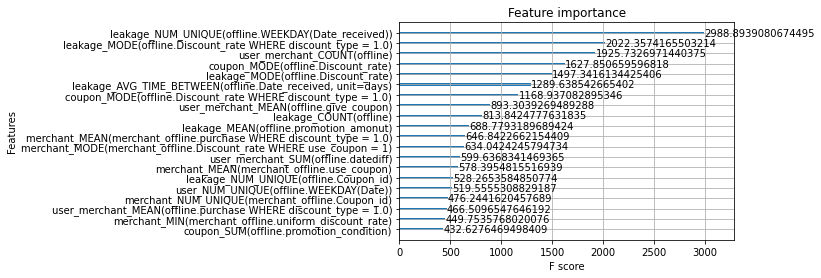

In [273]:
xgb.plot_importance(model,importance_type='gain', max_num_features=20)

In [274]:
model.predict(dtest).shape

(113640,)

In [275]:
X_test.shape

(113640, 102)

In [276]:
df_test['Probability'] = model.predict(dtest)

In [277]:
df_test_origin = pd.read_csv('./dataset/ccf_offline_stage1_test_revised.csv')

In [278]:
df_test_origin['Probability'] = df_test.reset_index()['Probability']

In [279]:
df_test_origin[['User_id','Coupon_id','Date_received', 'Probability']].to_csv('submit_0304_2030.csv',index=False)

In [280]:
df_test_origin

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Probability
0,4129537,450,9983,30:5,1.0,20160712,0.188074
1,6949378,1300,3429,30:5,NaN,20160706,0.607727
2,2166529,7113,6928,200:20,5.0,20160727,0.083381
3,2166529,7113,1808,100:10,5.0,20160727,0.108039
4,6172162,7605,6500,30:1,2.0,20160708,0.323392
...,...,...,...,...,...,...,...
113635,5828093,5717,10418,30:5,10.0,20160716,0.164993
113636,6626813,1699,7595,30:1,NaN,20160707,0.639167
113637,6626813,7321,7590,50:5,NaN,20160712,0.498090
113638,4547069,760,13602,30:5,0.0,20160717,0.674142


In [281]:
df_feature_selected.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'datediff', 'target',
       'Date_received', 'Month_received', 'data',
       'leakage_MODE(offline.Discount_rate)', 'user_MODE(online.Action)',
       ...
       'merchant_MODE(merchant_offline.Discount_rate WHERE use_coupon = 1)',
       'merchant_NUM_UNIQUE(merchant_offline.WEEKDAY(Date_received))',
       'user_merchant_SUM(offline.promotion_amonut WHERE use_coupon = 1)',
       'user_MODE(offline.WEEKDAY(Date))', 'leakage_MEAN(offline.Distance)',
       'user_SUM(offline.give_coupon)', 'user_MODE(offline.Discount_rate)',
       'user_COUNT(online)', 'user_NUM_UNIQUE(online.WEEKDAY(Date))',
       'merchant_MIN(merchant_offline.Distance WHERE discount_type = 0.0)'],
      dtype='object', length=110)